In [11]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

### Data Extraction (from Alpha Vantage via their API)

For this project, I'll be using the American Airlines stock market prices from the past 20 years to make my predictions. The specific reason I picked this company over others is that it is bursting with different stock price behaviors over time. This will make the learning more robust and let us test how good the predictions are for a variety of situations.

Since stock prices come in several different flavors, we'll save them accordingly as:

- Open: Opening stock price of the day
- Close: Closing stock price of the day
- High: Highest stock price of the data
- Low: Lowest stock price of the day

In [12]:
api_key = 'LOC9YBYQ9T5BT0AL'

# American Airlines stock market prices
ticker = "AAL"

# JSON file with all the stock market data for AAL from the last 20 years
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

# Save data to this file
file_to_save = 'stock_market_data-%s.csv'%ticker

# If you haven't already saved data,
# grab the data from the url and store date, low, high, volume, close, open values to a Pandas DataFrame
if not os.path.exists(file_to_save):
    with urllib.request.urlopen(url_string) as url:
        data = json.loads(url.read().decode())
        # extract stock market data
        data = data['Time Series (Daily)']
        df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
        for k,v in data.items():
            date = dt.datetime.strptime(k, '%Y-%m-%d')
            data_row = [date.date(),float(v['3. low']),float(v['2. high']), float(v['4. close']),float(v['1. open'])]
            df.loc[-1,:] = data_row
            df.index = df.index + 1
    print('Data saved to : %s'%file_to_save)        
    df.to_csv(file_to_save)
else:
    print('File already exists. Loading data from CSV')
    df = pd.read_csv(file_to_save)

File already exists. Loading data from CSV


### Data Exploration

In [13]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
4894,0,2005-09-27,19.10,21.40,19.30,21.05
4893,1,2005-09-28,19.20,20.53,20.50,19.30
4892,2,2005-09-29,20.10,20.58,20.21,20.40
4891,3,2005-09-30,20.18,21.05,21.01,20.26
4890,4,2005-10-03,20.90,21.75,21.50,20.90


### Data Vizualization

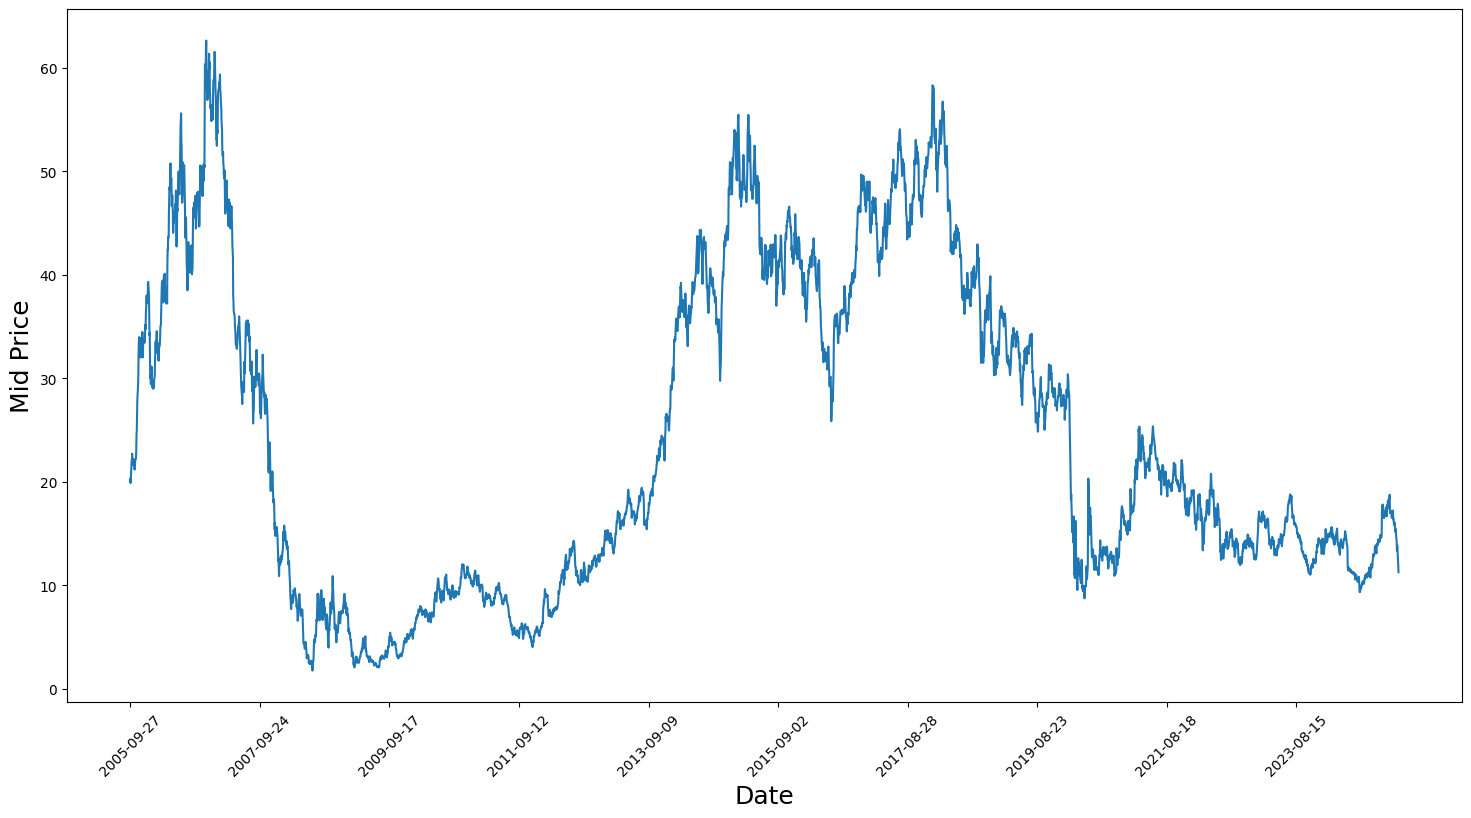

In [14]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

### Splitting the data into training and testing sets

In [15]:
# Calculate mid prices using pandas operations
df['Mid'] = (df['High'] + df['Low']) / 2.0

# Split data into train (80%) and test (20%) sets
total_rows = len(df)
train_size = int(0.8 * total_rows)

train_data = df['Mid'].iloc[:train_size].values
test_data = df['Mid'].iloc[train_size:].values

print(f"Training set size: {len(train_data)} days")
print(f"Test set size: {len(test_data)} days")

Training set size: 3916 days
Test set size: 979 days


### Data Normalization


In [16]:
# Scale the data to be between 0 and 1
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [17]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 500
for di in range(0, len(train_data), smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size])
    train_data[di:di+smoothing_window_size] = scaler.transform(train_data[di:di+smoothing_window_size])

# Normalize the last bit of remaining data
if di + smoothing_window_size < len(train_data):
    scaler.fit(train_data[di+smoothing_window_size:])
    train_data[di+smoothing_window_size:] = scaler.transform(train_data[di+smoothing_window_size:])

In [18]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data using the last fitted scaler
test_data = scaler.transform(test_data).reshape(-1)

In [19]:
# Now perform exponential moving average smoothing
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
    EMA = gamma * train_data[ti] + (1 - gamma) * EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data, test_data], axis=0)

### One-Step Ahead Prediction via Averaging

Averaging mechanisms allow us to predict by representing the future stock price as an average of the previously observed stock prices. Since doing this for more than one time step can produce quite bad results, we will look at two averaging techniques: below standard averaging and exponential moving average. We will evaluate both qualitatively (visual inspection) and quantitatively (Mean Squared Error) the results produced by the two algorithms.

The Mean Squared Error (MSE) can be calculated by taking the Squared Error between the true value at one step ahead and the predicted value and averaging it over all the predictions.

In [ ]:
# Standard Average

window_size = 50
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00723


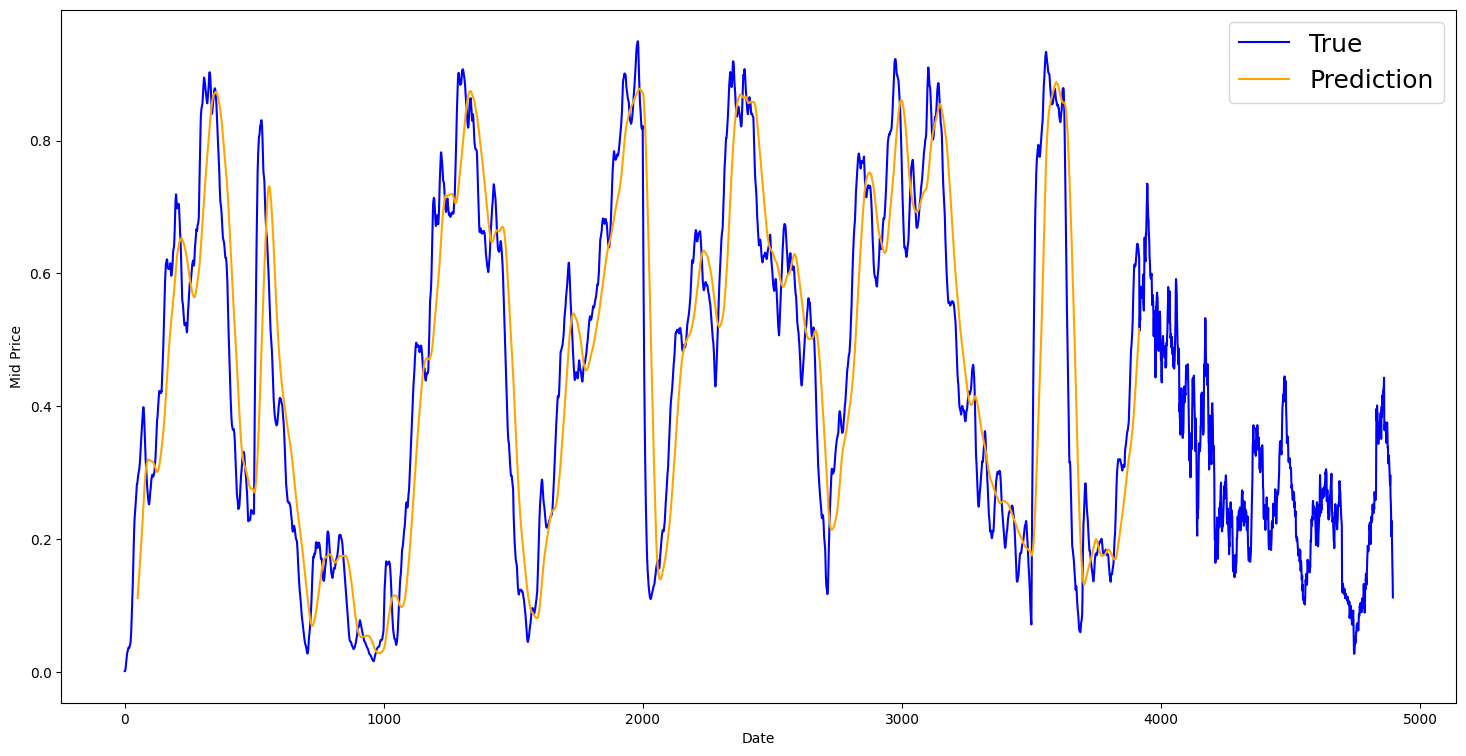

In [25]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()